

#  **Solving Taxi V3 Openai Gym using Expected Sarsa with Eligibility traces**






















In [1]:
import gym
import sys
import numpy as np
import bottleneck as bn
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from tqdm import trange
from gym import Env, spaces, utils
from numpy.random import random, choice
import matplotlib.pyplot as plt

**Functions for Epsilon greedy policy and Expected Q values**

In [2]:
def expected_Q(Q, epsilon, n_a):
    """
    This function calculates the expected Q value for the next state 
    no_a: No. of actions available
    epsilon: Exploration parameter
    Q: Action value function for the current state
    
    :return: Expected Q value for the next state 
    """

    E_Q=0
    max_value = max(Q)
    greedy_actions = [a for a in range(n_a) if Q[a] == max_value]
    non_greedy_action_probability = epsilon / n_a
    greedy_action_probability = ((1 - epsilon) / len(greedy_actions)) + non_greedy_action_probability
 
    for i in range(n_a):
      if Q[i] == max_value:
          E_Q += Q[i] * greedy_action_probability
      else:
          E_Q += Q[i] * non_greedy_action_probability

    return E_Q

In [3]:
def e_greedy(no_a,q, e):
    """
    This function performs the epsilon greedy action selection
    no_a: No. of actions available
    e: Exploration parameter
    q: Action value function for the current state
    :return: epsilon greedy action
    """

    k = np.random.rand()
    if k < e:
        a = np.random.randint(0, no_a)
    else:
        a = np.argmax(q)
    return a


**Environment and Parameters Setup**




In [4]:
env = gym.make("Taxi-v3")

# parameters for Expected sarsa(lambda)
episodes = 5000                 #number of episodes the agent will learn
gamma = 1.0                     #discount factor for rewards
alpha = 0.2                     #learning rate 
epsilon = 1.0                   #exploration parameter
epsilon_decay = 0.999           #decay in exploration per episode
eligibility_decay = 0.3         #decay for eligibilty traces

no_states = env.observation_space.n       #number of discrete states in the environment     
no_actions = env.action_space.n           #number of discrete actions in the environment    

#initializing the Q Table
Q = np.zeros((no_states, no_actions))

#list to store returns for every episode
returns = []







**Learning** 

In [5]:
for episode in trange(episodes):

  state = env.reset()

  #decaying the epsilon 
  epsilon = epsilon*epsilon_decay

  #choosing the action using the e-greedy policy 
  action = e_greedy(no_actions, Q[state,:], epsilon)    


  R = [None] # No first return

  #Initial Eligibilty trace defined as 0 at the start of an episode
  E = np.zeros((no_states, no_actions))         



  while True:
    
    #updating eligibility trace using the eligibility decay and gamma 
    E = eligibility_decay * gamma * E
    
    #updating the Eligibility trace for the latest state to 1
    E[state, action] += 1

    #choosing the new action and moving to the new state
    new_state, reward, done, info = env.step(action)
    new_action = e_greedy(no_actions, Q[new_state,:], epsilon)

    #append the reward
    R.append(reward)

    #updating TD error (delta) as per the expected sarsa formula
    delta = reward + gamma*expected_Q(Q[new_state, :], epsilon, no_actions) - Q[state, action]

    #updating the Q values using eligibility trace, delta and learning rate                  
    Q = Q + alpha * delta * E 

    #updating the current state and action 
    state, action = new_state, new_action

    #if goal is reached(dropoff)
    if done:
       break

  
  T = len(R)          #total timesteps the episode ran for
  
  G = 0               #total return of the episode

  # t = T-2, T-3, ..., 0
  t = T - 2

  #updating the return for the episode using timestep rewards
  while t >= 0:
    G = R[t+1] + gamma * G
    t = t - 1

  #appending the episode return to main array of returns
  returns.append(G)

100%|██████████| 5000/5000 [00:13<00:00, 360.55it/s] 


**Total sum of returns over 5000 episodes**

In [6]:
np.sum(returns)

-300784.0

**Q table after learning**

In [7]:
Q

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [-25.09092767, -16.21485822, -16.34277568, -19.79706885,
          9.962826  , -33.56269747],
       [ -8.20458682, -12.77838349,  -1.16046756,  -4.94469302,
         14.91444343, -10.77877576],
       ...,
       [-19.23381978,  -4.27349215, -16.0975365 , -20.4311793 ,
        -27.70096339, -26.66505743],
       [-27.07231267, -23.72405912, -28.50067456, -21.45263115,
        -32.86863686, -31.25728677],
       [ 12.23785068,   8.64894747,  11.42125926,  18.97465391,
          5.08031607,   1.28908326]])

**Learning Curve ( Moving Average Return(window 100) vs Epsiode)**

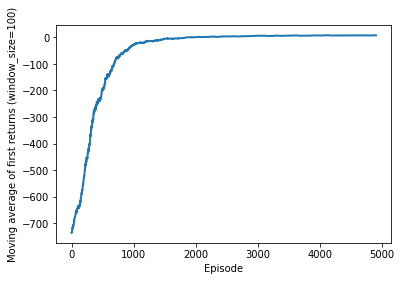

In [8]:
window_size = 100
averaged_returns = np.zeros(len(returns)-window_size+1)

for i in range(len(averaged_returns)):
  averaged_returns[i] = np.mean(returns[i:i+window_size])

plt.plot(averaged_returns, linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Moving average of first returns (window_size={})".format(window_size))
plt.show()

**Testing the environment with Learned Q Values**

In [9]:
testepisodes=100        #number of test episodes to be tested
testreturns=[]          #List to store return for every episode

In [10]:
for episode in trange(testepisodes):
  state_=env.reset()
  done_=False
  totalreward=0

  while True:
    env.render()
    action_=np.argmax(Q[state_,:])   #choosing the best action as per learned Q values
    newstate, reward_, done_, info=env.step(action_)
    totalreward += reward_
    if done_:
      testreturns.append(totalreward)
      print("Episode Score=", totalreward)
      break
    state_=newstate

env.close()

 18%|█▊        | 18/100 [00:00<00:00, 174.04it/s]

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |


 80%|████████  | 80/100 [00:00<00:00, 189.10it/s]

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| :_| : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R:_| : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
Episode Score= 8
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : 

100%|██████████| 100/100 [00:00<00:00, 185.05it/s]

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y

In [11]:
print("Total sum of scores =", sum(testreturns))
print("Average score per episode =", np.sum(testreturns)/testepisodes)

Total sum of scores = 808
Average score per episode = 8.08
